In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import keras.models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LeakyReLU 
import os
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Networks

## Discriminator

In [2]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(16,)))
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation=tf.nn.sigmoid))

    return model

## Generator 

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(16,)))
    
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(16))

    return model

In [4]:
generator = make_generator_model()

noise = tf.random.normal([100, 16])
generated_data = generator(noise, training=False)
#generated_data

In [5]:
discriminator = make_discriminator_model()

In [6]:
decision = discriminator(generated_data)
#decision

# Loss functions

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers 

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training

In [12]:
EPOCHS = 200
noise_dim = 16
num_examples_to_generate = 100
#BUFFER_SIZE = 60000
BATCH_SIZE = 100

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for n_batch, batch in enumerate(dataset):
            X_batch = batch.reshape(100,16)
            train_step(X_batch)
        
        test_data = generator(seed, training=False).numpy()
        test_data = np.argmax(test_data,1)
        plt.hist(test_data , bins = 20,  range=(0, 20), alpha=0.5, weights=np.ones(len(test_data)) / len(test_data))
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.show()


    # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,epochs, seed)

# Data

In [15]:
# Number training data samples
N = 10000

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

In [16]:
bins = np.linspace(0, 15, num=16 )
bin_indices = np.digitize(data, bins) - 1

In [17]:
data_temp = ((np.arange(16) == bin_indices[:,None]).astype(int))

(array([1642., 2159., 1576., 1132.,  832.,  546.,  421.,  315.,  257.,
         150.,  154.,  117.,   96.,   63.,   68.,  472.]),
 array([ 0.    ,  0.9375,  1.875 ,  2.8125,  3.75  ,  4.6875,  5.625 ,
         6.5625,  7.5   ,  8.4375,  9.375 , 10.3125, 11.25  , 12.1875,
        13.125 , 14.0625, 15.    ]),
 <BarContainer object of 16 artists>)

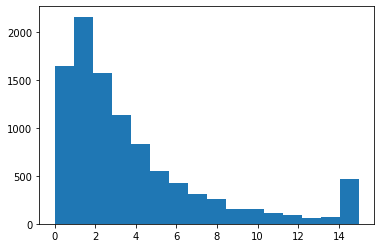

In [18]:
plt.hist(bin_indices, bins = 16)

In [19]:
data_loader = DataLoader(data_temp, batch_size=BATCH_SIZE, shuffle=True)

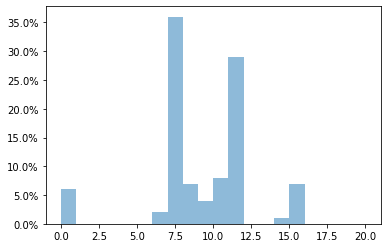

Time for epoch 1 is 0.8881332874298096 sec


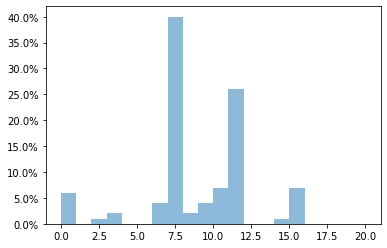

Time for epoch 2 is 0.23955821990966797 sec


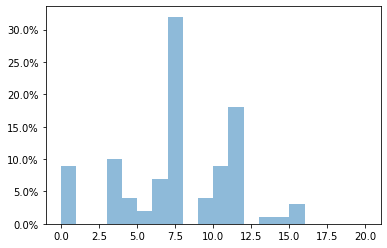

Time for epoch 3 is 0.2236003875732422 sec


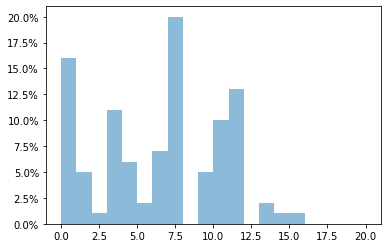

Time for epoch 4 is 0.22938036918640137 sec


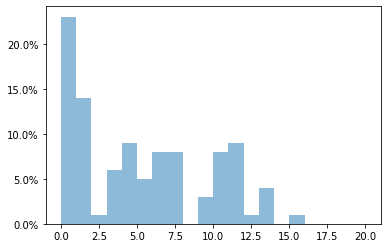

Time for epoch 5 is 0.20559477806091309 sec


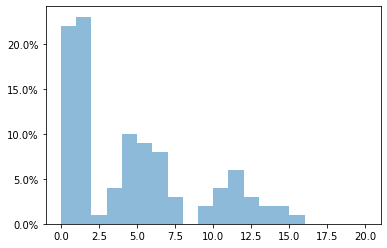

Time for epoch 6 is 0.2349226474761963 sec


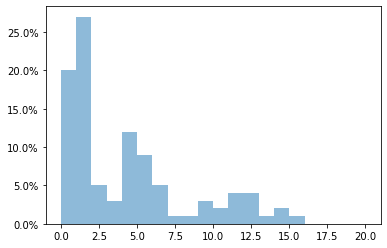

Time for epoch 7 is 0.2178492546081543 sec


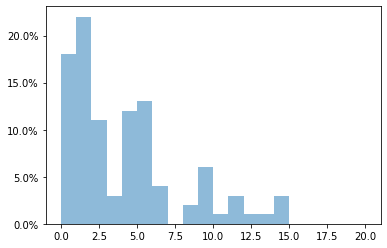

Time for epoch 8 is 0.26990342140197754 sec


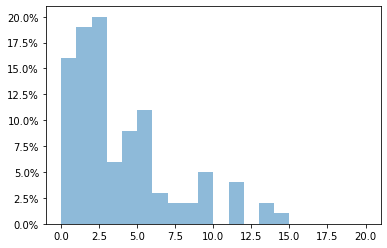

Time for epoch 9 is 0.2671947479248047 sec


Time for epoch 10 is 0.24833965301513672 sec


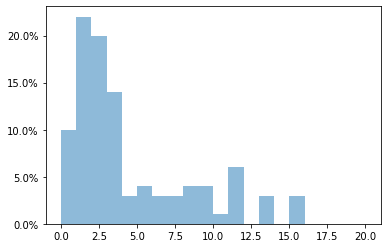

Time for epoch 11 is 0.23210668563842773 sec


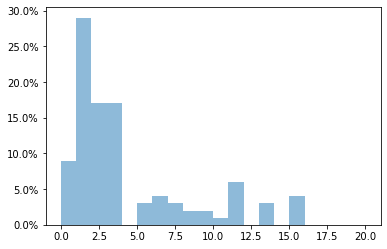

Time for epoch 12 is 0.2214970588684082 sec


Time for epoch 13 is 0.24552202224731445 sec


Time for epoch 14 is 0.20801210403442383 sec


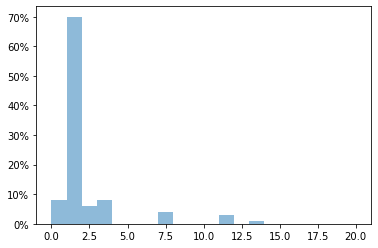

Time for epoch 15 is 0.25354623794555664 sec


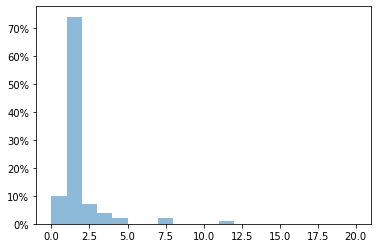

Time for epoch 16 is 0.20391035079956055 sec


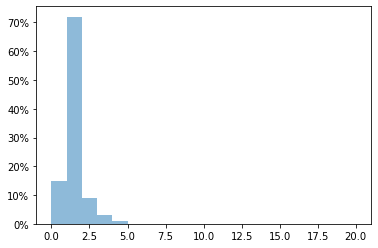

Time for epoch 17 is 0.2422797679901123 sec


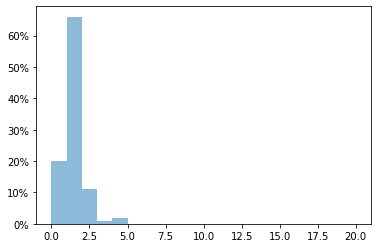

Time for epoch 18 is 0.2621450424194336 sec


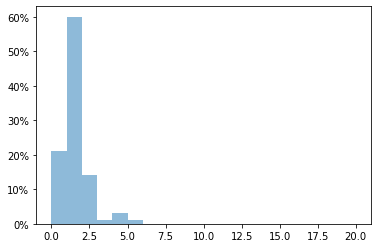

Time for epoch 19 is 0.38515496253967285 sec


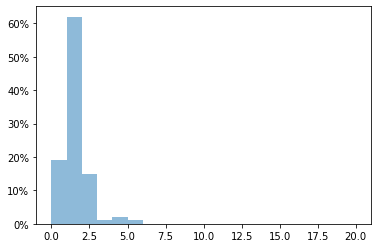

Time for epoch 20 is 0.22867083549499512 sec


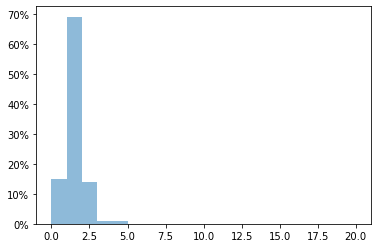

Time for epoch 21 is 0.21393036842346191 sec


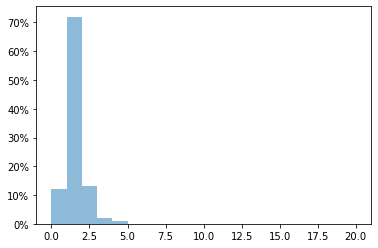

Time for epoch 22 is 0.26951026916503906 sec


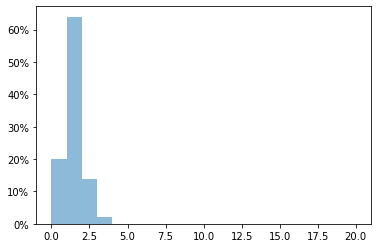

Time for epoch 23 is 0.1989126205444336 sec


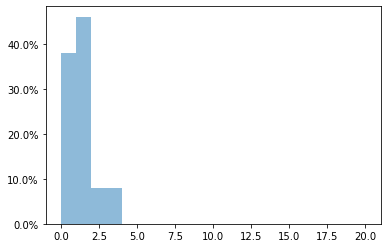

Time for epoch 24 is 0.21653270721435547 sec


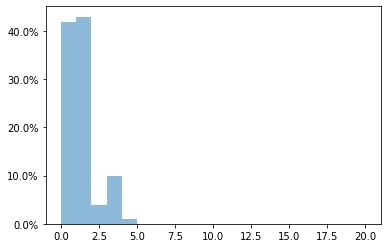

Time for epoch 25 is 0.20760822296142578 sec


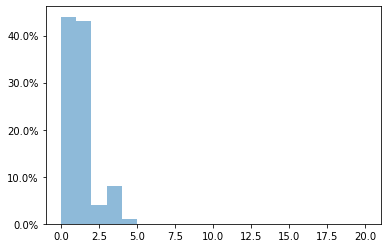

Time for epoch 26 is 0.24742603302001953 sec


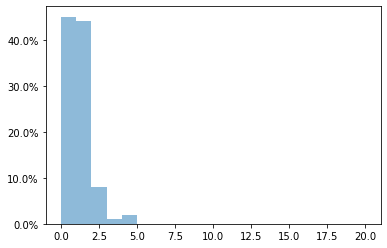

Time for epoch 27 is 0.20972776412963867 sec


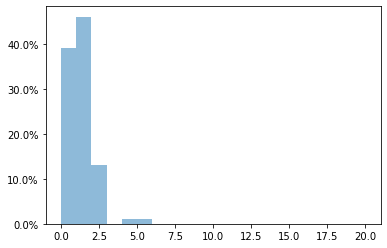

Time for epoch 28 is 0.20331835746765137 sec


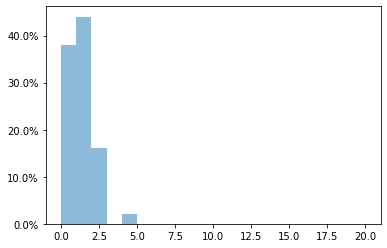

Time for epoch 29 is 0.20345735549926758 sec


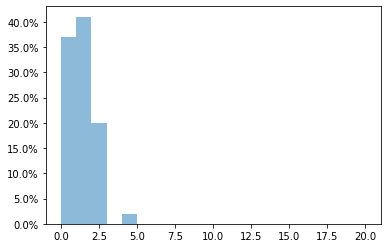

Time for epoch 30 is 0.25071096420288086 sec


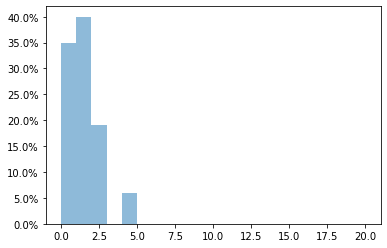

Time for epoch 31 is 0.2572152614593506 sec


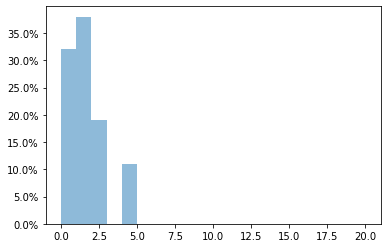

Time for epoch 32 is 0.23302745819091797 sec


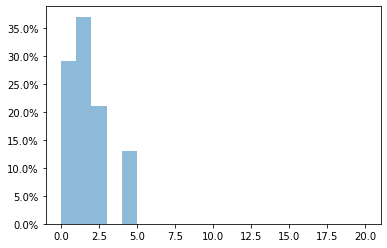

Time for epoch 33 is 0.23717546463012695 sec


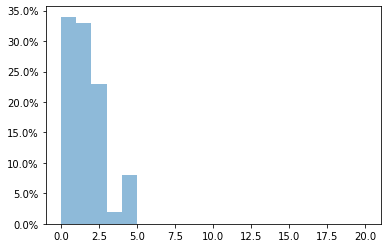

Time for epoch 34 is 0.21629858016967773 sec


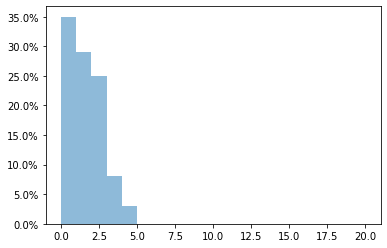

Time for epoch 35 is 0.23213529586791992 sec


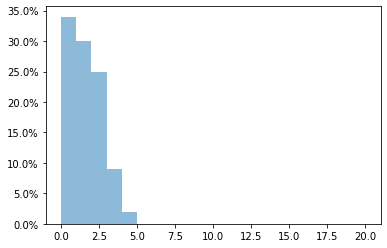

Time for epoch 36 is 0.22385740280151367 sec


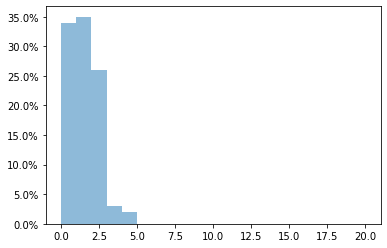

Time for epoch 37 is 0.2215871810913086 sec


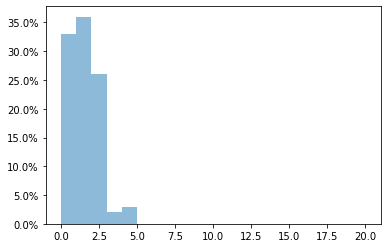

Time for epoch 38 is 0.23022079467773438 sec


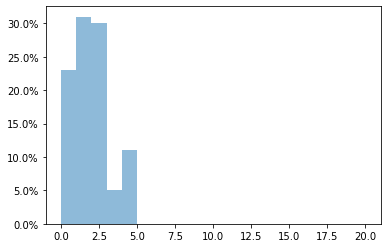

Time for epoch 39 is 0.2193155288696289 sec


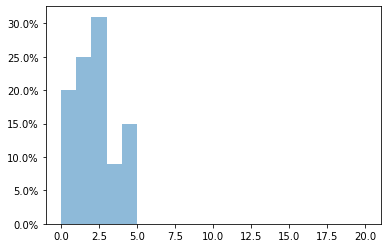

Time for epoch 40 is 0.35393428802490234 sec


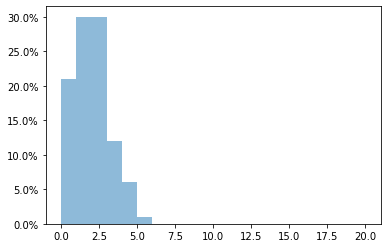

Time for epoch 41 is 0.22133398056030273 sec


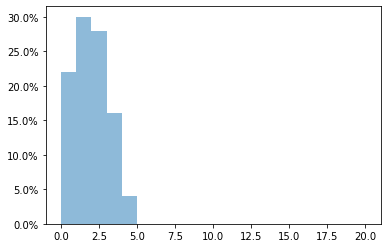

Time for epoch 42 is 0.2315044403076172 sec


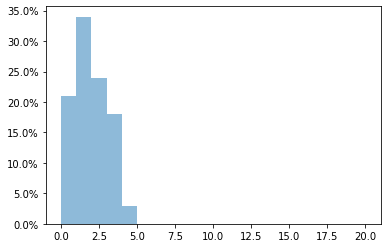

Time for epoch 43 is 0.2208411693572998 sec


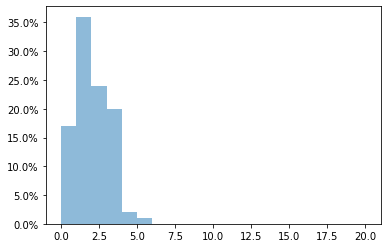

Time for epoch 44 is 0.2286074161529541 sec


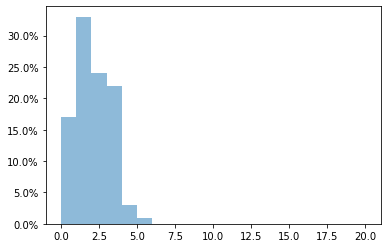

Time for epoch 45 is 0.25321269035339355 sec


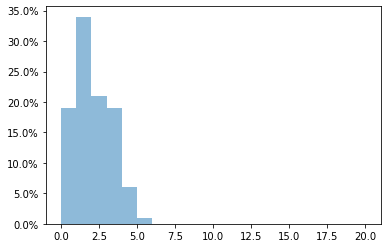

Time for epoch 46 is 0.21742820739746094 sec


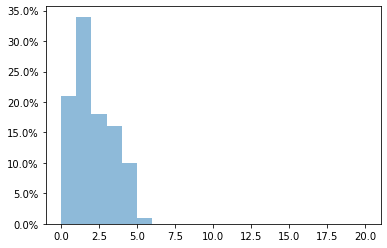

Time for epoch 47 is 0.24643611907958984 sec


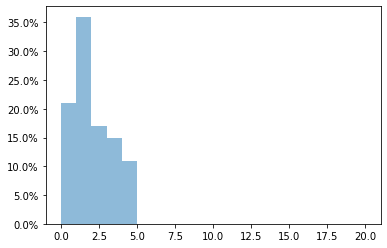

Time for epoch 48 is 0.2297196388244629 sec


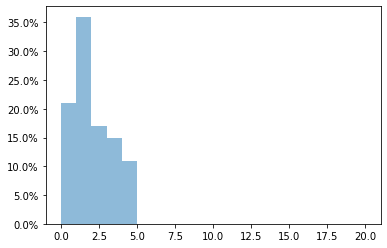

Time for epoch 49 is 0.2201685905456543 sec


Time for epoch 50 is 0.23562979698181152 sec


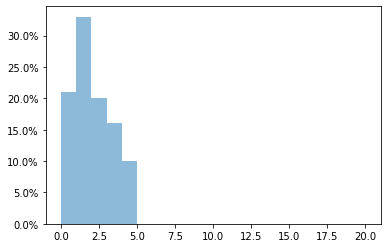

Time for epoch 51 is 0.21341156959533691 sec


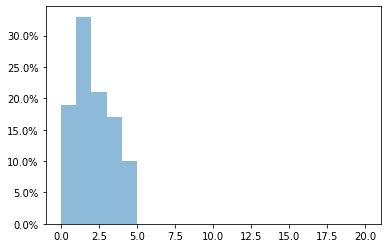

Time for epoch 52 is 0.21456313133239746 sec


Time for epoch 53 is 0.2383594512939453 sec


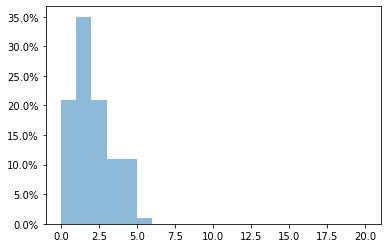

Time for epoch 54 is 0.23421359062194824 sec


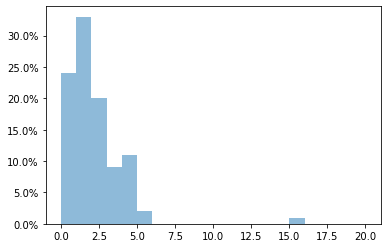

Time for epoch 55 is 0.21459674835205078 sec


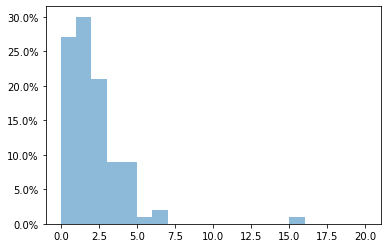

Time for epoch 56 is 0.2464127540588379 sec


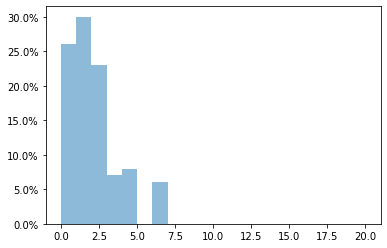

Time for epoch 57 is 0.24112915992736816 sec


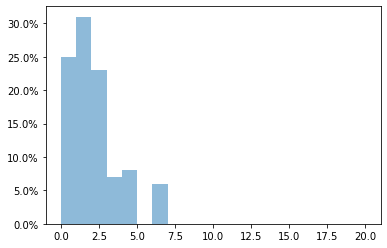

Time for epoch 58 is 0.2197890281677246 sec


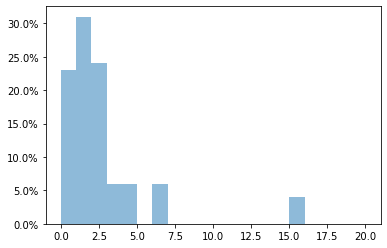

Time for epoch 59 is 0.21982145309448242 sec


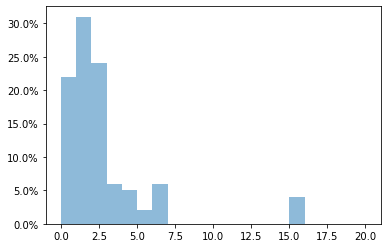

Time for epoch 60 is 0.24779129028320312 sec


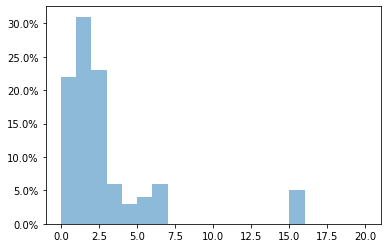

Time for epoch 61 is 0.3311331272125244 sec


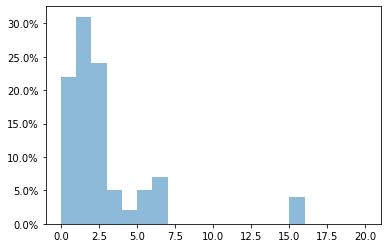

Time for epoch 62 is 0.20598673820495605 sec


Time for epoch 63 is 0.22217059135437012 sec


Time for epoch 64 is 0.22407293319702148 sec


Time for epoch 65 is 0.20720148086547852 sec


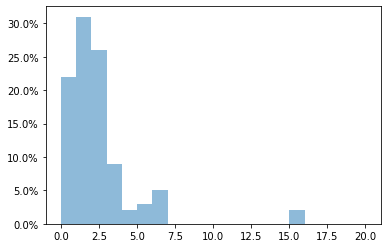

Time for epoch 66 is 0.21509265899658203 sec


Time for epoch 67 is 0.23081684112548828 sec


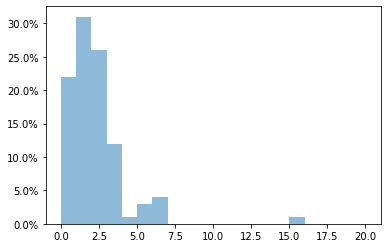

Time for epoch 68 is 0.2199866771697998 sec


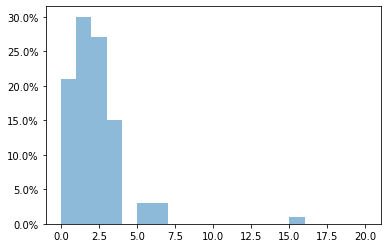

Time for epoch 69 is 0.19952702522277832 sec


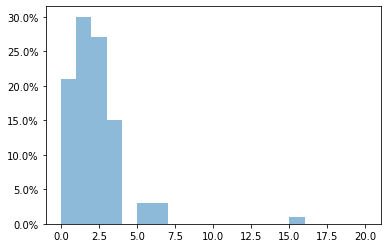

Time for epoch 70 is 0.2164325714111328 sec


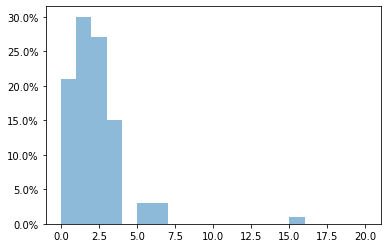

Time for epoch 71 is 0.21449565887451172 sec


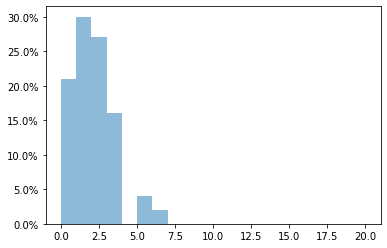

Time for epoch 72 is 0.2064359188079834 sec


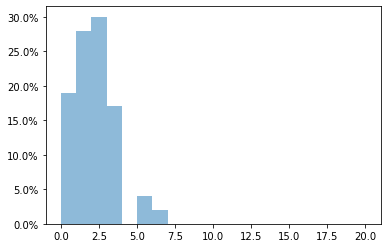

Time for epoch 73 is 0.21076440811157227 sec


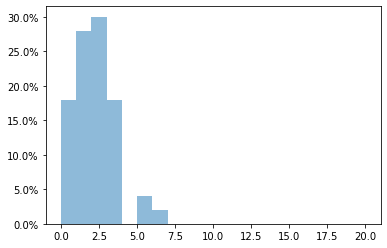

Time for epoch 74 is 0.21843242645263672 sec


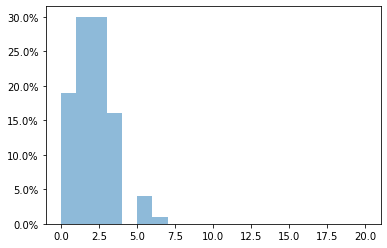

Time for epoch 75 is 0.24881863594055176 sec


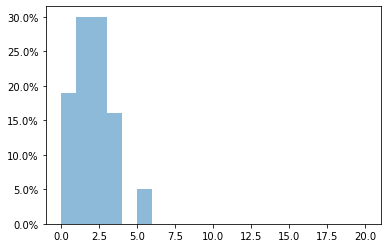

Time for epoch 76 is 0.21877789497375488 sec


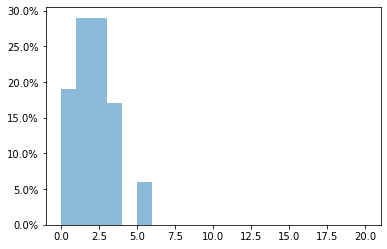

Time for epoch 77 is 0.21662688255310059 sec


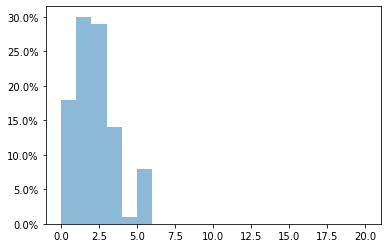

Time for epoch 78 is 0.21608901023864746 sec


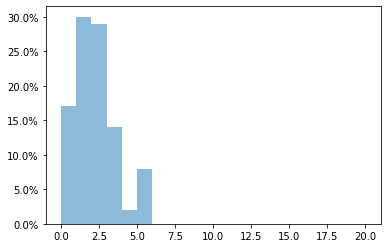

Time for epoch 79 is 0.23621845245361328 sec


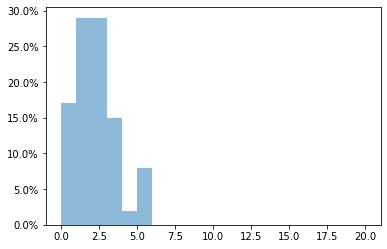

Time for epoch 80 is 0.22484302520751953 sec


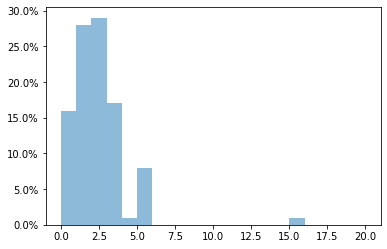

Time for epoch 81 is 0.21170473098754883 sec


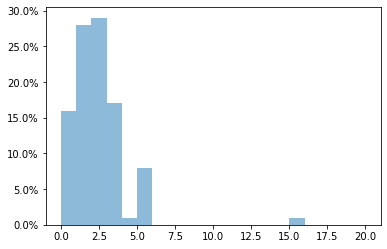

Time for epoch 82 is 0.32580995559692383 sec


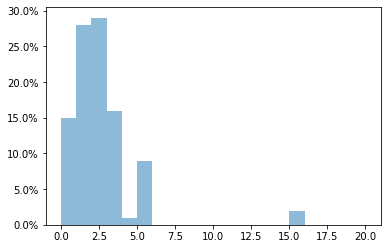

Time for epoch 83 is 0.24438142776489258 sec


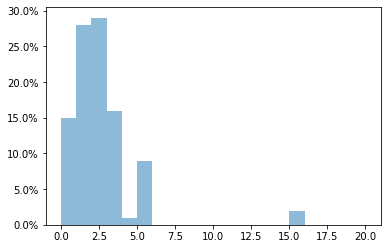

Time for epoch 84 is 0.19600605964660645 sec


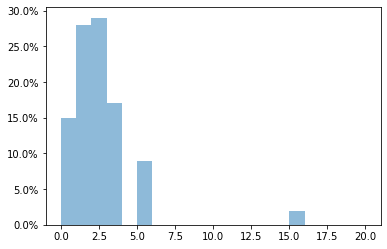

Time for epoch 85 is 0.2237846851348877 sec


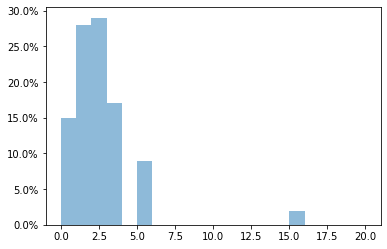

Time for epoch 86 is 0.21102237701416016 sec


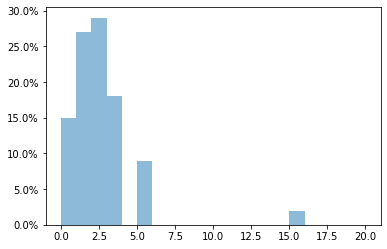

Time for epoch 87 is 0.22674870491027832 sec


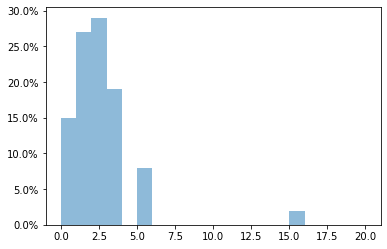

Time for epoch 88 is 0.22490549087524414 sec


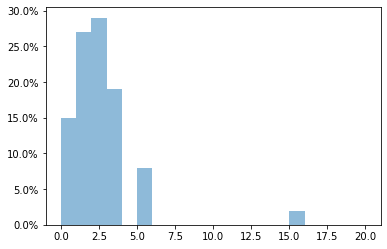

Time for epoch 89 is 0.21056199073791504 sec


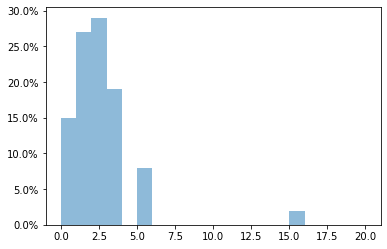

Time for epoch 90 is 0.23643112182617188 sec


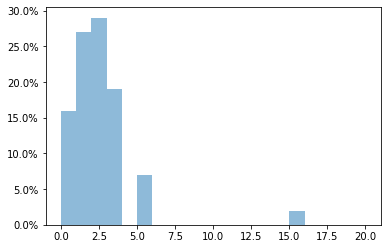

Time for epoch 91 is 0.224229097366333 sec


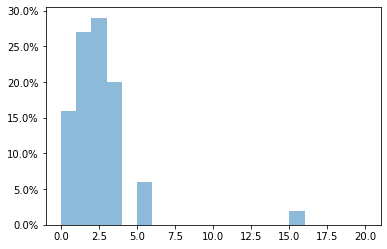

Time for epoch 92 is 0.21513700485229492 sec


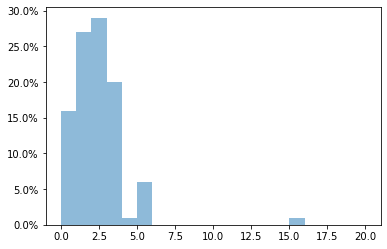

Time for epoch 93 is 0.21288108825683594 sec


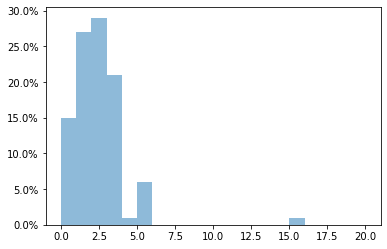

Time for epoch 94 is 0.22722077369689941 sec


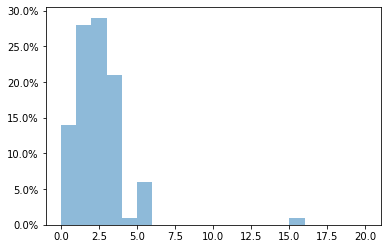

Time for epoch 95 is 0.2444605827331543 sec


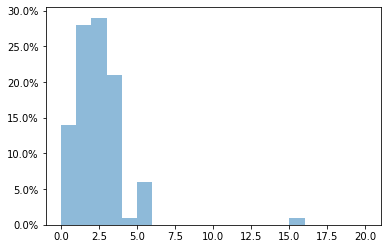

Time for epoch 96 is 0.2543754577636719 sec


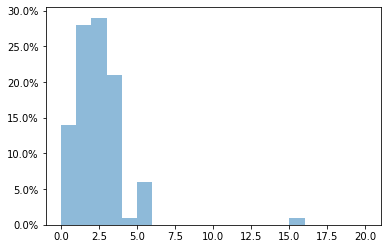

Time for epoch 97 is 0.22028779983520508 sec


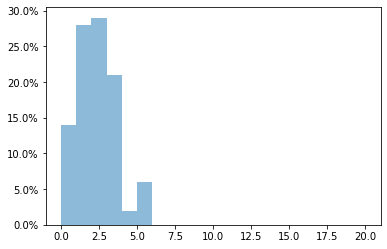

Time for epoch 98 is 0.22221684455871582 sec


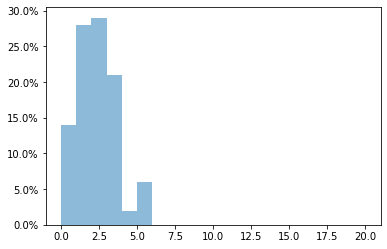

Time for epoch 99 is 0.2253398895263672 sec


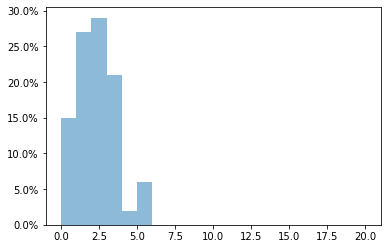

Time for epoch 100 is 0.20993947982788086 sec


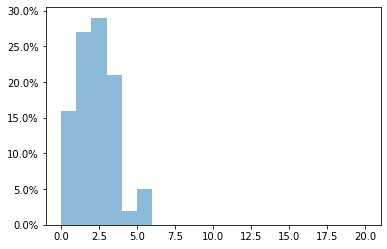

Time for epoch 101 is 0.2158207893371582 sec


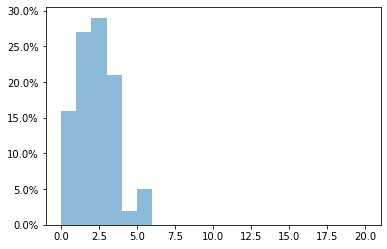

Time for epoch 102 is 0.23305368423461914 sec


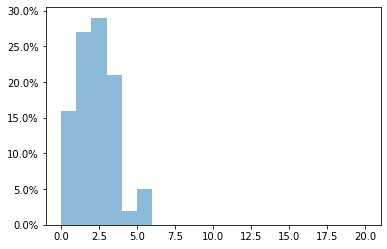

Time for epoch 103 is 0.38498830795288086 sec


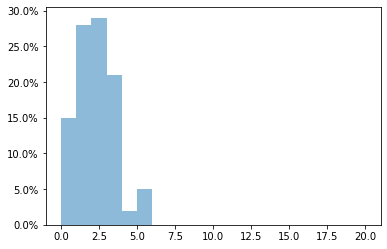

Time for epoch 104 is 0.22950243949890137 sec


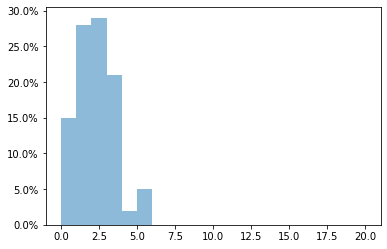

Time for epoch 105 is 0.2449352741241455 sec


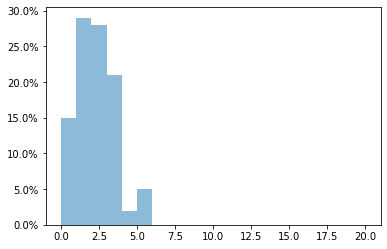

Time for epoch 106 is 0.20987224578857422 sec


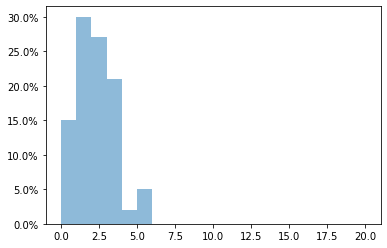

Time for epoch 107 is 0.2155776023864746 sec


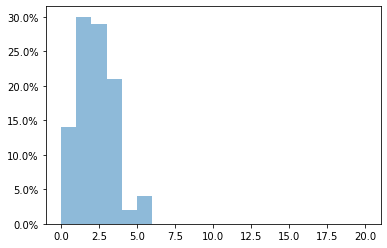

Time for epoch 108 is 0.21210360527038574 sec


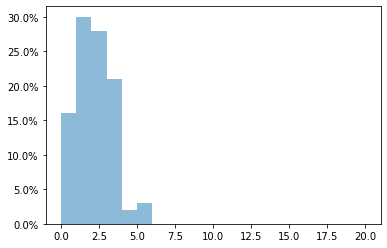

Time for epoch 109 is 0.20691561698913574 sec


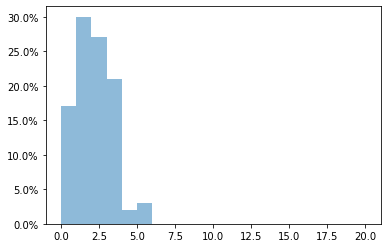

Time for epoch 110 is 0.22372817993164062 sec


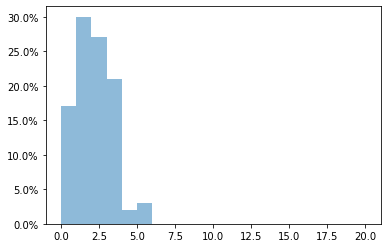

Time for epoch 111 is 0.20869970321655273 sec


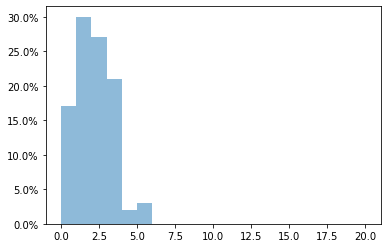

Time for epoch 112 is 0.2228987216949463 sec


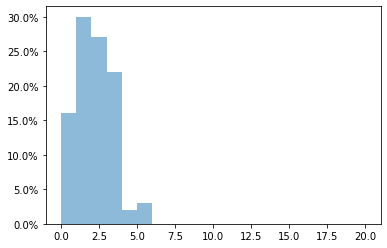

Time for epoch 113 is 0.2162647247314453 sec


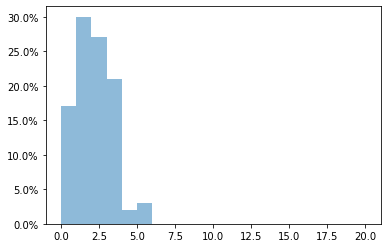

Time for epoch 114 is 0.2505621910095215 sec


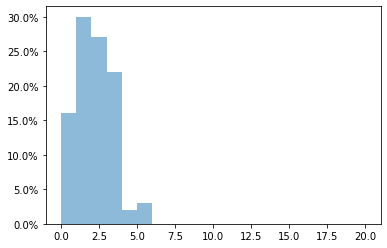

Time for epoch 115 is 0.2544667720794678 sec


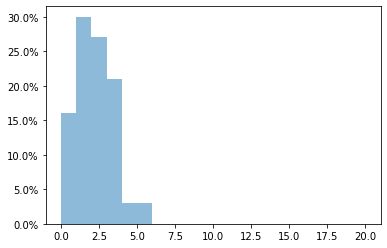

Time for epoch 116 is 0.2088608741760254 sec


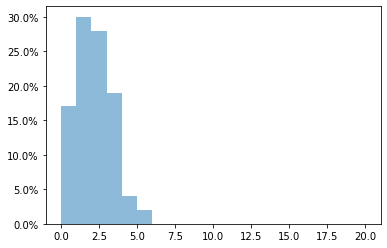

Time for epoch 117 is 0.23428010940551758 sec


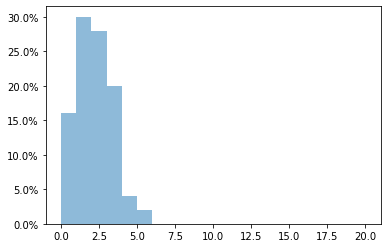

Time for epoch 118 is 0.25621700286865234 sec


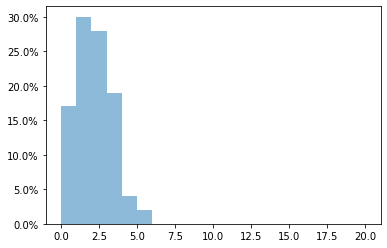

Time for epoch 119 is 0.22371888160705566 sec


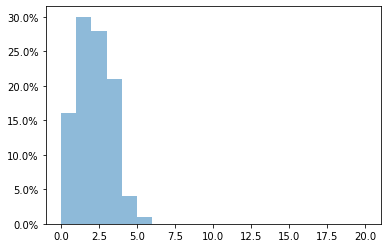

Time for epoch 120 is 0.24558448791503906 sec


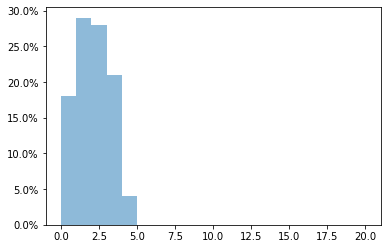

Time for epoch 121 is 0.2265775203704834 sec


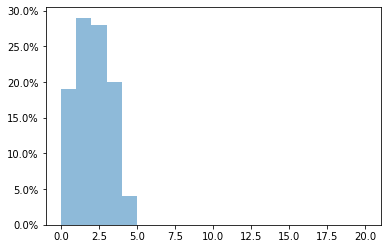

Time for epoch 122 is 0.2655928134918213 sec


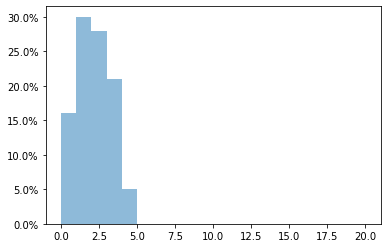

Time for epoch 123 is 0.22667765617370605 sec


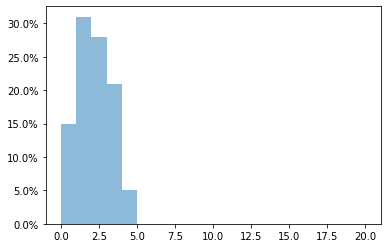

Time for epoch 124 is 0.3435401916503906 sec


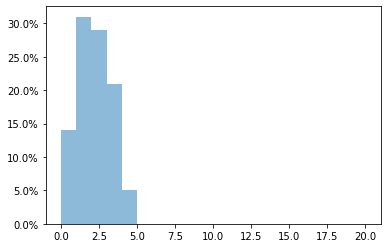

Time for epoch 125 is 0.2462153434753418 sec


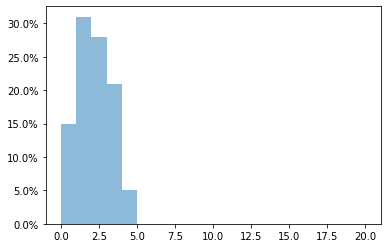

Time for epoch 126 is 0.24445319175720215 sec


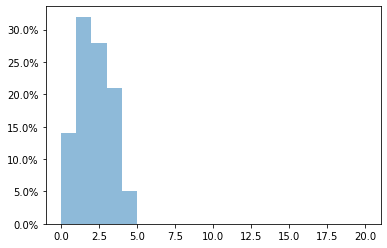

Time for epoch 127 is 0.2346053123474121 sec


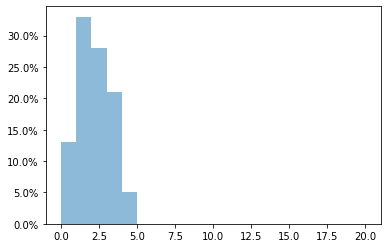

Time for epoch 128 is 0.35945987701416016 sec


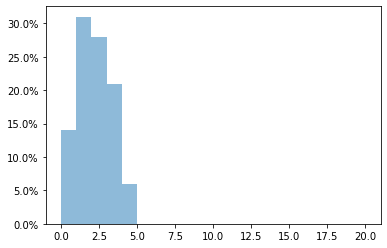

Time for epoch 129 is 0.2565011978149414 sec


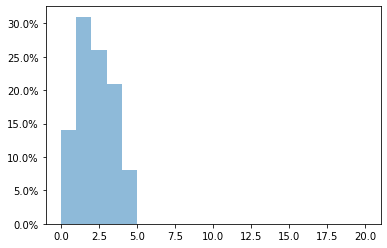

Time for epoch 130 is 0.26312971115112305 sec


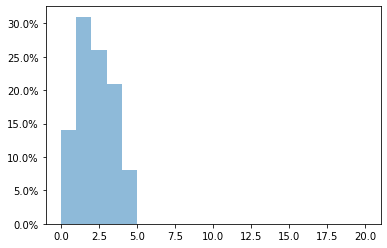

Time for epoch 131 is 0.21982288360595703 sec


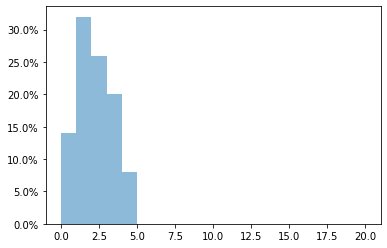

Time for epoch 132 is 0.2344965934753418 sec


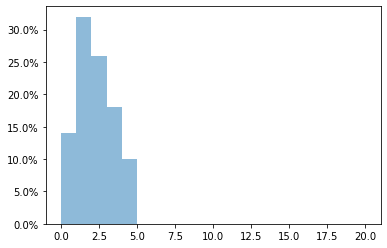

Time for epoch 133 is 0.21713900566101074 sec


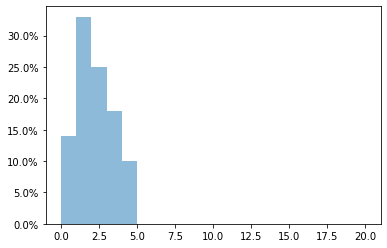

Time for epoch 134 is 0.22059202194213867 sec


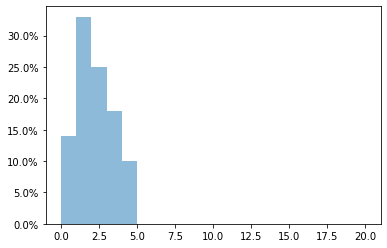

Time for epoch 135 is 0.23761796951293945 sec


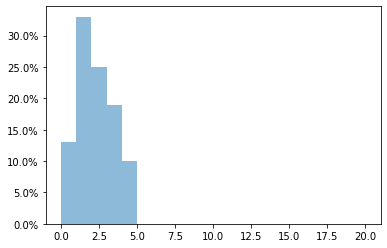

Time for epoch 136 is 0.2327578067779541 sec


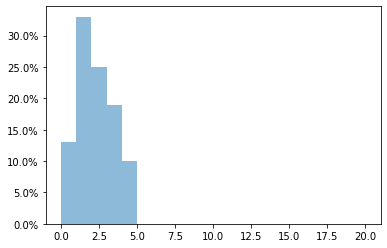

Time for epoch 137 is 0.2547416687011719 sec


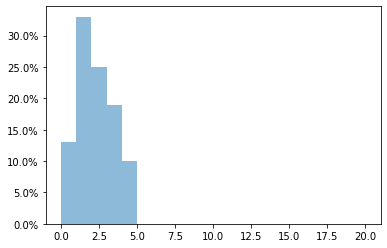

Time for epoch 138 is 0.2986166477203369 sec


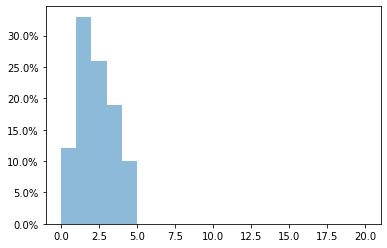

Time for epoch 139 is 0.31961536407470703 sec


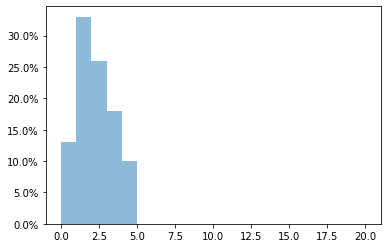

Time for epoch 140 is 0.4105656147003174 sec


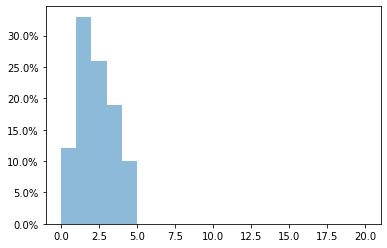

Time for epoch 141 is 0.489088773727417 sec


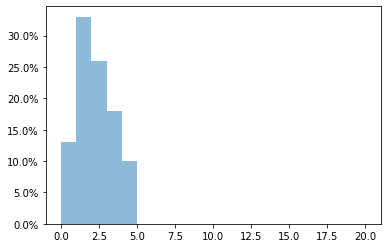

Time for epoch 142 is 0.42983269691467285 sec


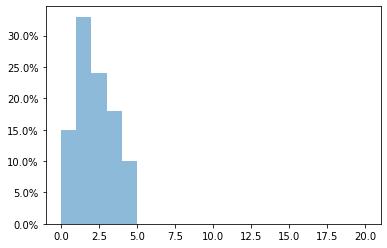

Time for epoch 143 is 0.3573112487792969 sec


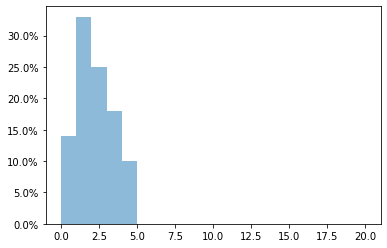

Time for epoch 144 is 0.4758014678955078 sec


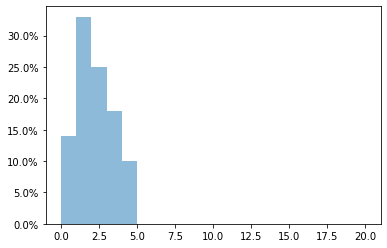

Time for epoch 145 is 0.5626339912414551 sec


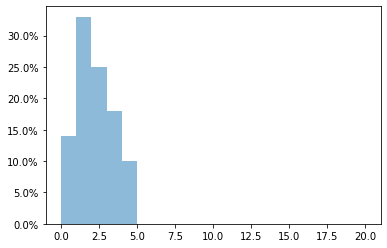

Time for epoch 146 is 0.328751802444458 sec


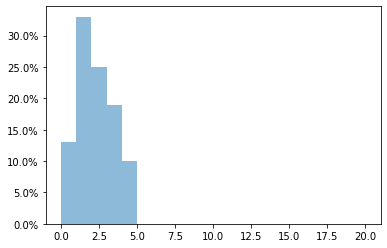

Time for epoch 147 is 0.33733534812927246 sec


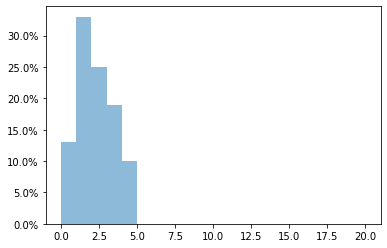

Time for epoch 148 is 0.33046913146972656 sec


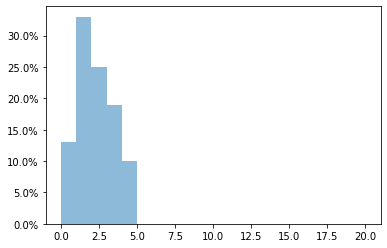

Time for epoch 149 is 0.30293917655944824 sec


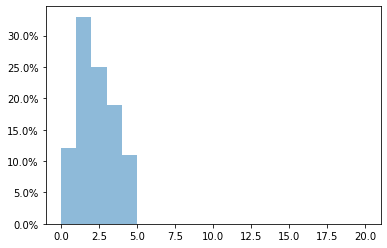

Time for epoch 150 is 0.349041223526001 sec


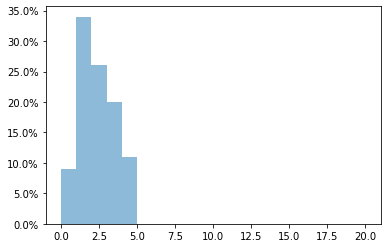

Time for epoch 151 is 0.3852207660675049 sec


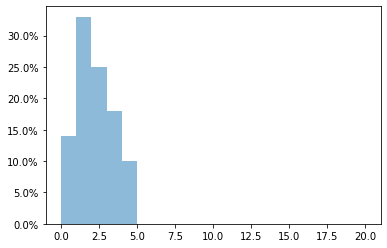

Time for epoch 152 is 0.24365973472595215 sec


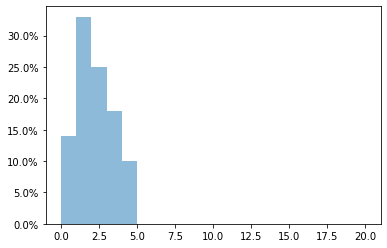

Time for epoch 153 is 0.22173047065734863 sec


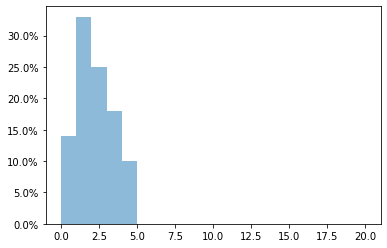

Time for epoch 154 is 0.22156739234924316 sec


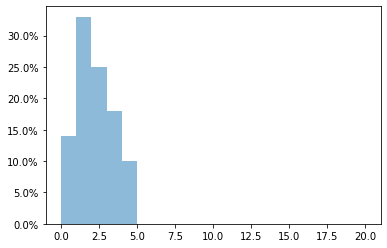

Time for epoch 155 is 0.2162010669708252 sec


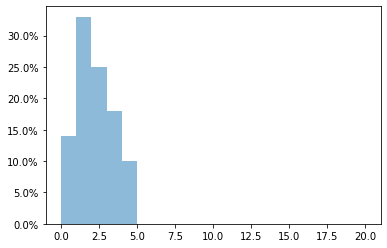

Time for epoch 156 is 0.2175595760345459 sec


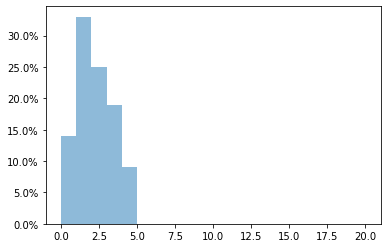

Time for epoch 157 is 0.21898531913757324 sec


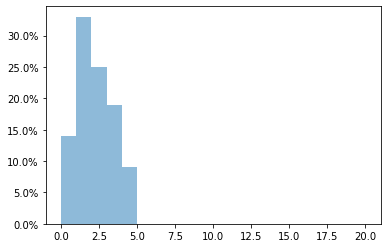

Time for epoch 158 is 0.21563148498535156 sec


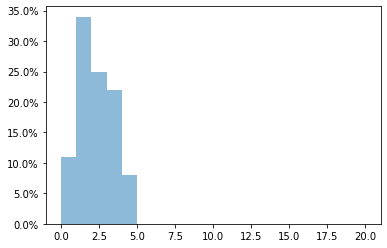

Time for epoch 159 is 0.2214977741241455 sec


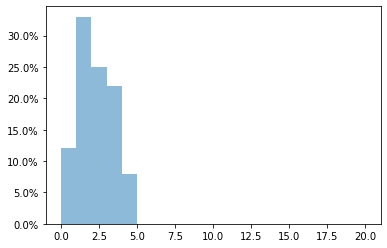

Time for epoch 160 is 0.21710991859436035 sec


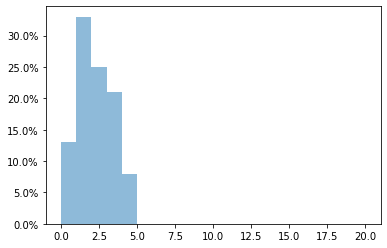

Time for epoch 161 is 0.21538662910461426 sec


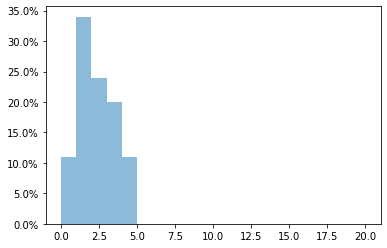

Time for epoch 162 is 0.2373056411743164 sec


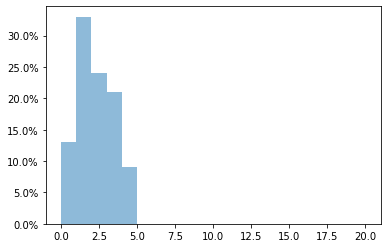

Time for epoch 163 is 0.22066617012023926 sec


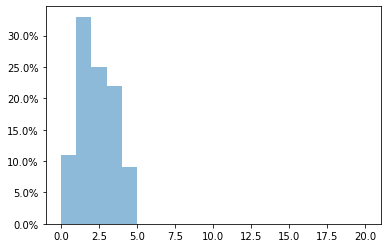

Time for epoch 164 is 0.22547268867492676 sec


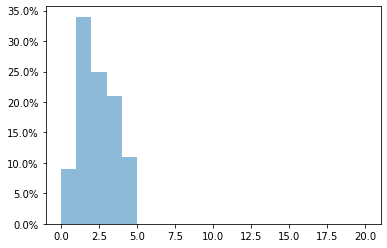

Time for epoch 165 is 0.2599811553955078 sec


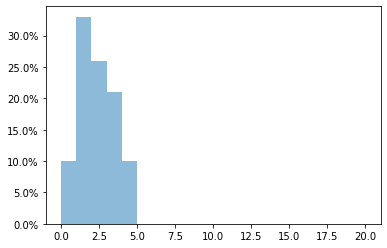

Time for epoch 166 is 0.34761977195739746 sec


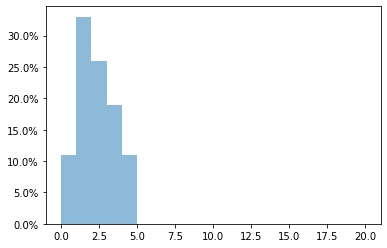

Time for epoch 167 is 0.226759672164917 sec


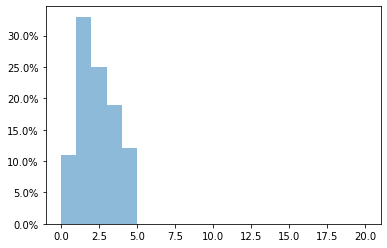

Time for epoch 168 is 0.2136075496673584 sec


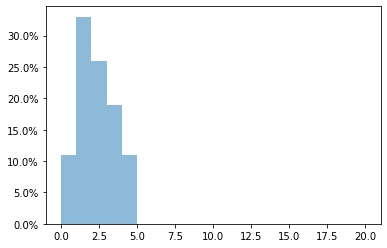

Time for epoch 169 is 0.21973133087158203 sec


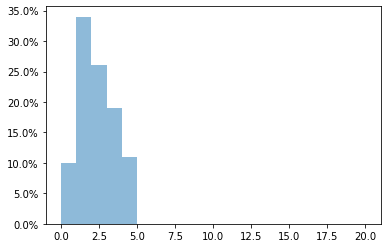

Time for epoch 170 is 0.22205543518066406 sec


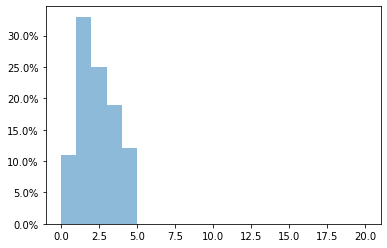

Time for epoch 171 is 0.21486163139343262 sec


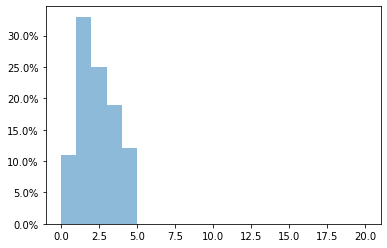

Time for epoch 172 is 0.224365234375 sec


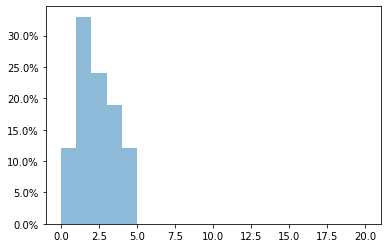

Time for epoch 173 is 0.21961164474487305 sec


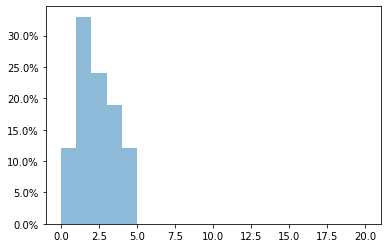

Time for epoch 174 is 0.22237181663513184 sec


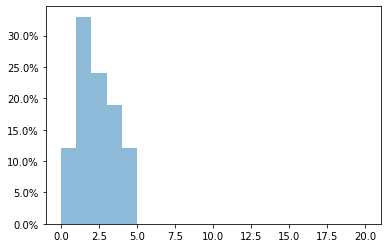

Time for epoch 175 is 0.2170116901397705 sec


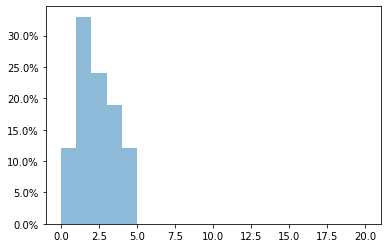

Time for epoch 176 is 0.21640539169311523 sec


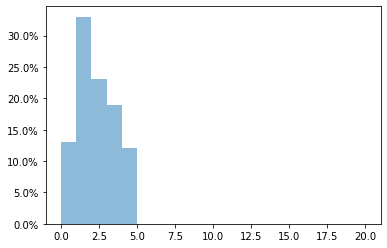

Time for epoch 177 is 0.22615742683410645 sec


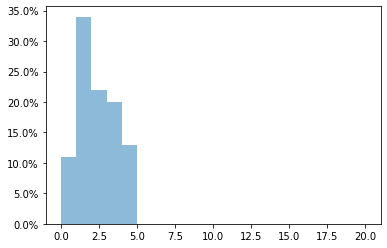

Time for epoch 178 is 0.22030878067016602 sec


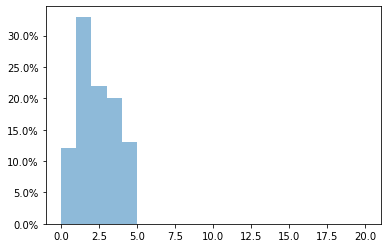

Time for epoch 179 is 0.2207934856414795 sec


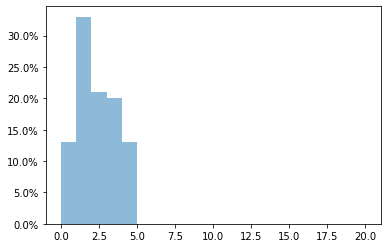

Time for epoch 180 is 0.2530944347381592 sec


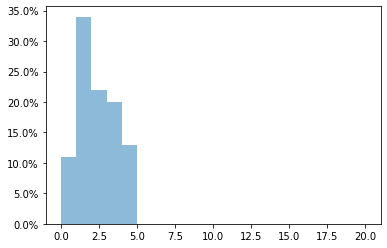

Time for epoch 181 is 0.22879528999328613 sec


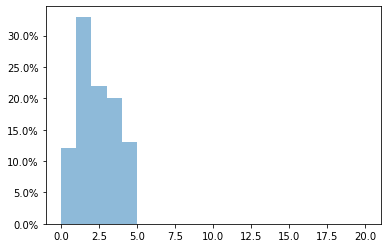

Time for epoch 182 is 0.22722315788269043 sec


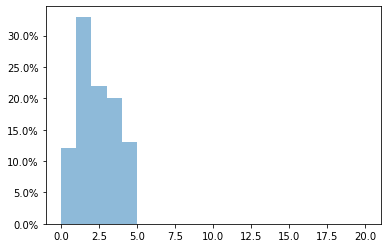

Time for epoch 183 is 0.21675658226013184 sec


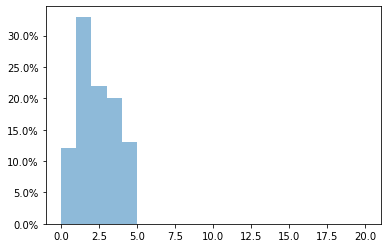

Time for epoch 184 is 0.21828055381774902 sec


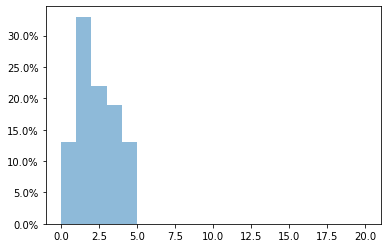

Time for epoch 185 is 0.23482513427734375 sec


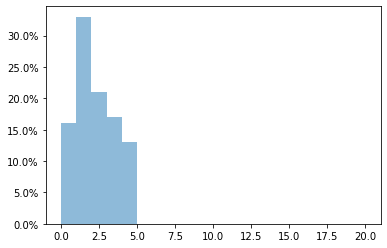

Time for epoch 186 is 0.2183830738067627 sec


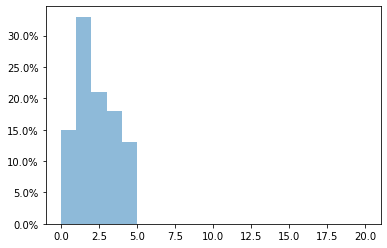

Time for epoch 187 is 0.35061049461364746 sec


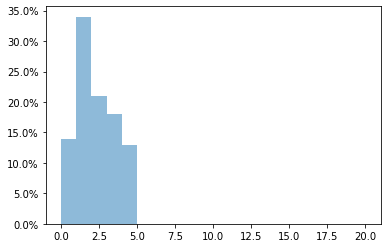

Time for epoch 188 is 0.2411198616027832 sec


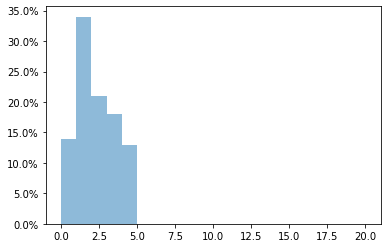

Time for epoch 189 is 0.227370023727417 sec


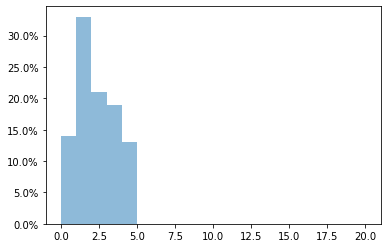

Time for epoch 190 is 0.21687602996826172 sec


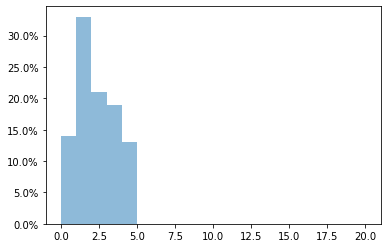

Time for epoch 191 is 0.21913647651672363 sec


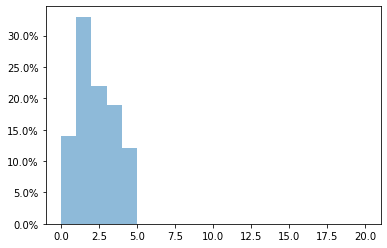

Time for epoch 192 is 0.22460246086120605 sec


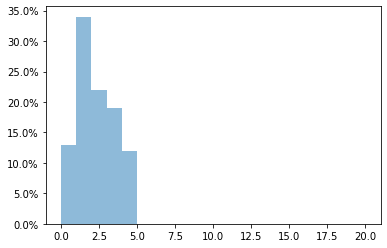

Time for epoch 193 is 0.2233295440673828 sec


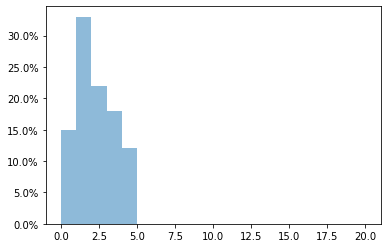

Time for epoch 194 is 0.21785664558410645 sec


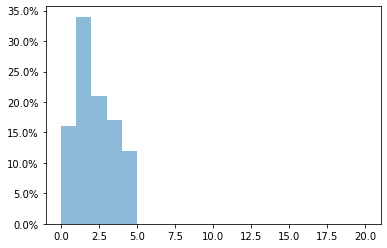

Time for epoch 195 is 0.24831819534301758 sec


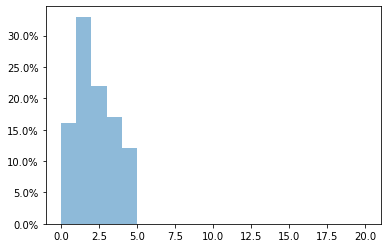

Time for epoch 196 is 0.21854782104492188 sec


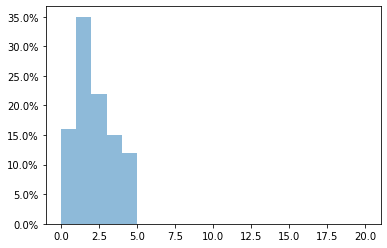

Time for epoch 197 is 0.22400403022766113 sec


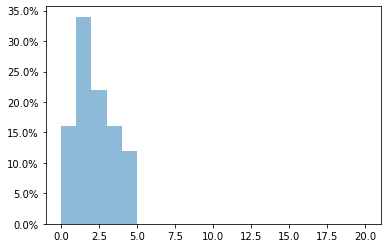

Time for epoch 198 is 0.21781039237976074 sec


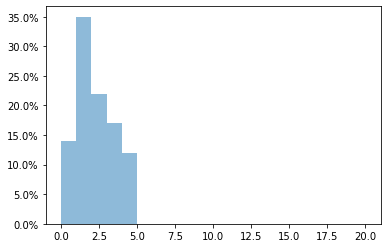

Time for epoch 199 is 0.21718811988830566 sec


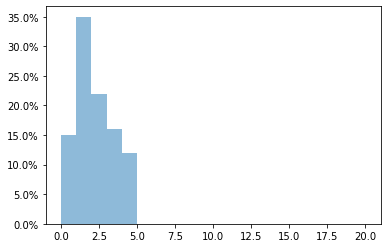

Time for epoch 200 is 0.23299646377563477 sec


In [20]:
train(data_loader, EPOCHS)

In [23]:
noise = tf.random.normal([100, 16])
generated_data = generator(noise, training=False).numpy()
generated_data = np.argmax(generated_data,1)

In [25]:
noise = tf.random.normal([100, 16])
generated_data = generator(noise, training=False)
generated_data

<tf.Tensor: shape=(100, 16), dtype=float32, numpy=
array([[ 8.16364884e-02,  1.35207251e-01,  7.11036921e-01, ...,
         7.38722272e-03,  7.63775967e-03, -9.29471862e-04],
       [ 6.62885487e-01,  1.67582110e-02,  1.23948663e-01, ...,
         3.39625962e-03,  9.25360899e-03, -1.89955905e-03],
       [ 2.56300807e-01,  3.83483022e-02,  5.44577897e-01, ...,
         1.05485935e-02,  1.01528158e-02, -1.61486142e-03],
       ...,
       [ 7.15839863e-02,  7.58448780e-01,  2.71299481e-02, ...,
         1.19813532e-03,  7.72705721e-03,  6.54005399e-03],
       [-7.03018308e-01,  2.00317693e+00, -6.19071275e-02, ...,
         1.87619869e-03, -1.22579653e-03, -1.22867459e-02],
       [-1.58440173e-02,  1.02778816e+00,  6.99838996e-03, ...,
         5.20431343e-03,  4.12653014e-03,  1.75544119e-04]], dtype=float32)>

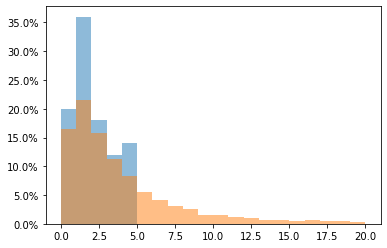

In [24]:
plt.hist(generated_data , bins = 20,  range=(0, 20), alpha=0.5, weights=np.ones(len(generated_data)) / len(generated_data))
plt.hist(data , bins = 20,  range=(0, 20), alpha=0.5, weights=np.ones(len(data)) / len(data))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()